#### 샴 네트워크는 각 input에 대한 Vector를 생성하고 비교하는데 사용되는
#### 두 개 이상의 동일한 하위 네트워크를 포함하는 네트워크 아키텍쳐 유형입니다.
# 즉 Multi-task Learning

In [ ]:
# 이 예제에서는 3개의 동일한 하위 네트워크가 있는 샴 네트워크를 사용합니다.
# 모델에 3개의 이미지를 제공할 것인데, 2개는 유사한 것이고 (Anchor and possitive smapel)
# 세번째 이비지는 관련 없습니다.
# 출처 : https://keras.io/examples/vision/siamese_network/

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
from pathlib import Path
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
from tensorflow.keras.applications import resnet


In [2]:
target_shape = (200, 200)

In [3]:
# Dataset Load

In [4]:
anchor_images_path = "C:\\Users\\jesung\\github\\CodingLife\\20220324\\dataset\\left\\"
positive_images_path = "C:\\Users\\jesung\\github\\CodingLife\\20220324\\dataset\\right\\"

In [5]:
# Data Prepare

In [6]:
def preprocess_image(filename):
    """
    Load the specified file as a JPEG image, preprocess it and
    resize it to the target shape.
    """

    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, target_shape)
    return image


def preprocess_triplets(anchor, positive, negative):
    """
    Given the filenames corresponding to the three images, load and
    preprocess them.
    """

    return (
        preprocess_image(anchor),
        preprocess_image(positive),
        preprocess_image(negative),
    )

In [7]:
# 데이터 파이프라인을 설정

In [8]:
# We need to make sure both the anchor and positive images are loaded in
# sorted order so we can match them together.
anchor_images = sorted(
    [str(anchor_images_path + f) for f in os.listdir(anchor_images_path)]
)

positive_images = sorted(
    [str(positive_images_path + f) for f in os.listdir(positive_images_path)]
)

image_count = len(anchor_images)

anchor_dataset = tf.data.Dataset.from_tensor_slices(anchor_images)
positive_dataset = tf.data.Dataset.from_tensor_slices(positive_images)

# To generate the list of negative images, let's randomize the list of
# available images and concatenate them together.
rng = np.random.RandomState(seed=42)
rng.shuffle(anchor_images)
rng.shuffle(positive_images)

negative_images = anchor_images + positive_images
np.random.RandomState(seed=32).shuffle(negative_images)

negative_dataset = tf.data.Dataset.from_tensor_slices(negative_images)
negative_dataset = negative_dataset.shuffle(buffer_size=4096)

dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))
dataset = dataset.shuffle(buffer_size=1024)
dataset = dataset.map(preprocess_triplets)

# Let's now split our dataset in train and validation.
train_dataset = dataset.take(round(image_count * 0.8))
val_dataset = dataset.skip(round(image_count * 0.8))

train_dataset = train_dataset.batch(32, drop_remainder=False)
train_dataset = train_dataset.prefetch(8)

val_dataset = val_dataset.batch(32, drop_remainder=False)
val_dataset = val_dataset.prefetch(8)

In [9]:
# 트리플렛의 몇 가지 예를 살펴보겠습니다. 세 번째 이미지는 항상 다른 반면 처음 두 이미지는 어떻게 유사하게 보이는지 확인하십시오.

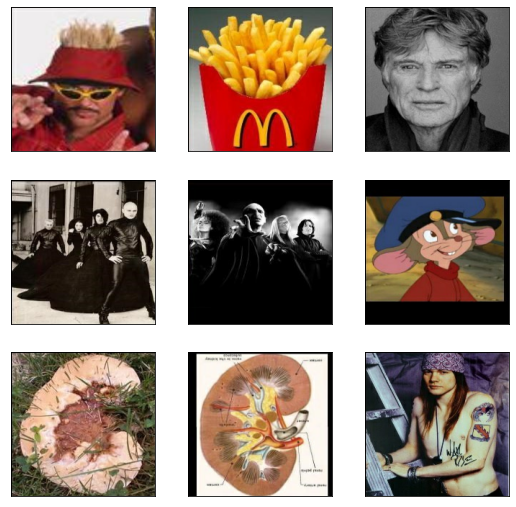

In [10]:
def visualize(anchor, positive, negative):
    """Visualize a few triplets from the supplied batches."""

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(3, 3)
    for i in range(3):
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative[i])


visualize(*list(train_dataset.take(1).as_numpy_iterator())[0])

# 임베딩 생성기 모델 설정
#Siamese 네트워크는 삼중항의 각 이미지에 대한 임베딩을 생성합니다. 이를 위해 ImageNet에서 사전 훈련된 ResNet50 모델을 사용하고 여기에 몇 개의 Dense레이어를 연결하여 이러한 임베딩을 분리하는 방법을 배울 것입니다.

모델의 모든 레이어의 가중치를 레이어까지 고정합니다 conv5_block1_out. 이는 모델이 이미 학습한 가중치에 영향을 미치지 않도록 하는 데 중요합니다. 우리는 훈련하는 동안 가중치를 미세 조정할 수 있도록 맨 아래 몇 개의 레이어를 훈련 가능한 상태로 둘 것입니다.

In [11]:
base_cnn = resnet.ResNet50(
    weights="imagenet", input_shape=target_shape + (3,), include_top=False
)

flatten = layers.Flatten()(base_cnn.output)
dense1 = layers.Dense(512, activation="relu")(flatten)
dense1 = layers.BatchNormalization()(dense1)
dense2 = layers.Dense(256, activation="relu")(dense1)
dense2 = layers.BatchNormalization()(dense2)
output = layers.Dense(256)(dense2)

embedding = Model(base_cnn.input, output, name="Embedding")

trainable = False
for layer in base_cnn.layers:
    if layer.name == "conv5_block1_out":
        trainable = True
    layer.trainable = trainable

In [12]:
# 샴 네트워크 모델 설정
#샴 네트워크는 각각의 삼중항 이미지를 입력으로 받아 임베딩을 생성하고 앵커와 포지티브 임베딩 사이의 거리와 앵커와 네거티브 임베딩 사이의 거리를 출력합니다.

#거리를 계산하기 위해 DistanceLayer두 값을 튜플로 반환하는 사용자 지정 레이어를 사용할 수 있습니다.

In [13]:
class DistanceLayer(layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)


anchor_input = layers.Input(name="anchor", shape=target_shape + (3,))
positive_input = layers.Input(name="positive", shape=target_shape + (3,))
negative_input = layers.Input(name="negative", shape=target_shape + (3,))

distances = DistanceLayer()(
    embedding(resnet.preprocess_input(anchor_input)),
    embedding(resnet.preprocess_input(positive_input)),
    embedding(resnet.preprocess_input(negative_input)),
)

siamese_network = Model(
    inputs=[anchor_input, positive_input, negative_input], outputs=distances
)

In [14]:
# 모든 것을 합치면
#이제 Siamese 네트워크에서 생성된 3개의 임베딩을 사용하여 삼중항 손실을 계산할 수 있도록 사용자 지정 훈련 루프가 있는 모델을 구현해야 합니다.
#Mean훈련 프로세스의 손실을 추적하기 위해 메트릭 인스턴스를 생성해 보겠습니다 .

In [15]:
class SiameseModel(Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.5):
        super(SiameseModel, self).__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        ap_distance, an_distance = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker]

# 훈련

In [17]:
siamese_model = SiameseModel(siamese_network)
siamese_model.compile(optimizer=optimizers.Adam(0.0001))
siamese_model.fit(train_dataset, epochs=10, validation_data=val_dataset)

Epoch 1/10
151/151 [==============================] - 147s 913ms/step - loss: 0.5016 - val_loss: 0.3868
Epoch 2/10
151/151 [==============================] - 135s 898ms/step - loss: 0.3892 - val_loss: 0.3594
Epoch 3/10
151/151 [==============================] - 135s 891ms/step - loss: 0.3723 - val_loss: 0.3521
Epoch 4/10
151/151 [==============================] - 135s 897ms/step - loss: 0.3521 - val_loss: 0.3391
Epoch 5/10
151/151 [==============================] - 135s 894ms/step - loss: 0.3469 - val_loss: 0.3405
Epoch 6/10
151/151 [==============================] - 138s 914ms/step - loss: 0.3272 - val_loss: 0.3154
Epoch 7/10
151/151 [==============================] - 472s 3s/step - loss: 0.3207 - val_loss: 0.3227
Epoch 8/10
151/151 [==============================] - 541s 4s/step - loss: 0.3073 - val_loss: 0.3197
Epoch 9/10
151/151 [==============================] - 541s 4s/step - loss: 0.3081 - val_loss: 0.3038
Epoch 10/10
151/151 [==============================] - 279s 2s/step - los

# 네트워크가 학습한 내용 검사

In [22]:
#이 시점에서 네트워크가 유사한 이미지에 속하는지 여부에 따라 임베딩을 분리하는 방법을 학습한 것을 확인할 수 있습니다.

#코사인 유사도 를 사용하여 임베딩 간의 유사성을 측정 할 수 있습니다 .

#데이터 세트에서 샘플을 선택하여 각 이미지에 대해 생성된 임베딩 간의 유사성을 확인하겠습니다

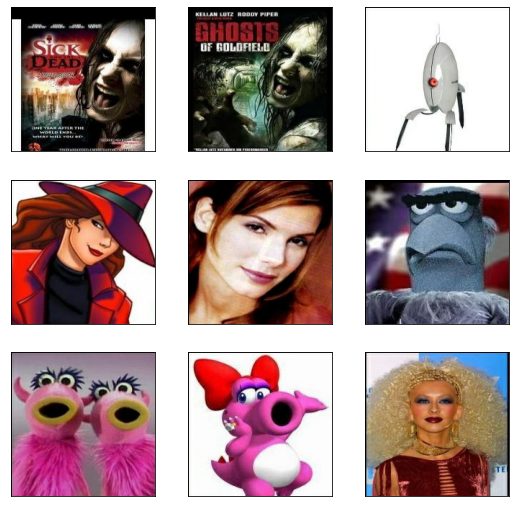

In [19]:
sample = next(iter(train_dataset))
visualize(*sample)

anchor, positive, negative = sample
anchor_embedding, positive_embedding, negative_embedding = (
    embedding(resnet.preprocess_input(anchor)),
    embedding(resnet.preprocess_input(positive)),
    embedding(resnet.preprocess_input(negative)),
)

In [20]:
#마지막으로 앵커와 포지티브 이미지 간의 코사인 유사도를 계산하고 앵커와 네거티브 이미지 간의 유사도와 비교할 수 있습니다.

#앵커와 포지티브 이미지 사이의 유사도가 앵커와 네거티브 이미지 간의 유사도보다 클 것으로 예상해야 합니다.

In [21]:
cosine_similarity = metrics.CosineSimilarity()

positive_similarity = cosine_similarity(anchor_embedding, positive_embedding)
print("Positive similarity:", positive_similarity.numpy())

negative_similarity = cosine_similarity(anchor_embedding, negative_embedding)
print("Negative similarity", negative_similarity.numpy())

Positive similarity: 0.99247086
Negative similarity 0.9895154
